# Transformer for Generation of music using VQVAE outputs

## Imports

In [1]:
try: 
    import librosa
except:
    !pip install librosa
try: 
    import optuna, plotly
except:
    !pip install optuna
    !pip install plotly


#Set Dir 
import sys, os
sys.path.append(os.path.abspath('..'))

# Torch
import torch
from torch import nn, Tensor
from torch.utils.data import DataLoader, Subset
import torch.optim as optim
import torch.nn.functional as F
import optuna, plotly
from optuna.importance import get_param_importances
from optuna.visualization import plot_param_importances
from transformers import get_linear_schedule_with_warmup
from collections import Counter
# Utils
import numpy as np
from numpy import ndarray
import logging, math


# Base Scripts
from Libraries.Utils import *
from Libraries.VQ_VAE import *
from Libraries.Transformer import *

## Setup

### Initial Setup

In [2]:
remote_kernel: bool = True
device: str = "cuda" if torch.cuda.is_available() else "cpu"
training_data_name: str = "../Data/training_v2_full"
test_data_name: str = "../Data/unseen_test_data.npy"
vq_vae_name: str = "VQ_VAE_v2"
vq_vae_path: str = OS().path_to_remote_path("../Models/{}".format(vq_vae_name), remote_kernel)
model_name: str = "transformer_v2"
full_model_path: str = OS().path_to_remote_path("../Models/{}".format(model_name), remote_kernel)

### Logging

In [3]:
logging_level: int = logging.INFO
logging.basicConfig(level=logging_level, format='%(asctime)s - %(levelname)s - %(message)s')
logger: logging.Logger = logging.getLogger(__name__)

### Data Hyperparameters

In [4]:
n_train_samples: int = 2048
batch_size: int = 16
n_workers: int = 1

### Load VQ VAE

In [5]:
vq_vae = VQVAE(input_emb_width=1, output_emb_width=64, k_bins=2048, levels=1, downs_t=[3], strides_t=[2]).to(device)

In [6]:
if os.path.exists(vq_vae_path):
    model = torch.load(vq_vae_path, map_location=device)
    vq_vae.load_state_dict(model["vq_vae"])
    logger.info(f"Model {vq_vae_name} loaded with {count_parameters(vq_vae)} Parameters")

2025-07-20 12:09:08,945 - INFO - Model VQ_VAE_v2 loaded with ~597.5k Parameters


### Data loading

In [7]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(training_data_name, remote_kernel))
md.create_validation_split()
train_dataset, val_dataset  = md.create_datasets()
logger.info(f"Created train dataset with length {len(md.train_dataset)} and validation dataset with length {len(md.val_dataset)}")
del md

2025-07-20 12:09:29,983 - INFO - Created train dataset with length 4267 and validation dataset with length 224


In [8]:
md = ModelData()
md.load_data_from_path(data_path=OS().path_to_remote_path(test_data_name, remote_kernel))
md.create_validation_split()
test_dataset, _ = md.create_datasets()
test_dataloader, _ = md.create_dataloaders(batch_size, num_workers=n_workers)
logger.info(f"Created test dataset with length {len(md.train_dataset)}")

2025-07-20 12:09:30,706 - INFO - Created test dataset with length 268


In [9]:
def generate_latent_repr(vq_vae: nn.Module, data: Dataset, batch_size: int = 24, device: str = "cpu") -> Dataset:
    data_loader = DataLoader(data, batch_size=batch_size, shuffle=False)
    converted_data = []
    vq_vae.eval()
    for b,_ in (data_loader):
        _, q_z, _, _ = vq_vae(b.unsqueeze(1).to(device))
        converted_data.append(q_z)
    vq_vae.train()
    new_data = torch.cat(converted_data, dim=0)
    return AudioDataset(new_data, data_type=torch.long)

In [10]:
latent_dataset = generate_latent_repr(vq_vae, train_dataset, 12, device)
latent_val_dataset = generate_latent_repr(vq_vae, val_dataset, 12, device)
train_dataloader = DataLoader(latent_dataset, batch_size, shuffle=False)
validation_dataloader = DataLoader(latent_val_dataset, batch_size, shuffle=False)

In [11]:
latent_test_dataset = generate_latent_repr(vq_vae, test_dataset, 12, device)
latent_test_dataloader = DataLoader(latent_test_dataset, batch_size, shuffle=False)

## Model Setup

### Hyperparameters

In [12]:
b1, b2 = (0.9, 0.99)
lr = 1e-5
n_epochs = 50 
restart_training: bool = True
training_seq_len: int = 2048

### Models

In [13]:
transformer = TransformerDec(vocab_size=2048, embed_size=1024, n_layers=6, forward_expansion=4, n_heads=8, pad_idx=-1, dropout=0.3, device=device, max_seq_len=2048).to(device)

### Optimizers & Schedulers

In [14]:
optimizer = optim.AdamW(transformer.parameters(), lr, (b1, b2))
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=10000, num_training_steps=n_epochs * len(train_dataloader), last_epoch=-1)

### Model Loading

In [15]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    transformer.load_state_dict(model["transformer"])

    if not restart_training:
        optimizer.load_state_dict(model["optim"])
        start_epoch = model.get("epoch", 0)
    logger.info(f"Model {model_name} loaded with {count_parameters(transformer)} Parameters")
else: 
    logger.info(f"Model {model_name} created with {count_parameters(transformer)} Parameters")

2025-07-20 12:11:19,320 - INFO - Model transformer_v2 created with ~81.88M Parameters


## Training

In [16]:
class SyntheticDataset(Dataset):
    def __init__(self, num_sequences=1000, seq_len=32768, vocab_size=2048, period=10):
        self.num_sequences = num_sequences
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.period = period
        self.data = self._generate_data()

    def _generate_data(self):
        # Generate periodic sequences: [0, 1, 2, ..., period-1, 0, 1, ...]
        pattern = torch.arange(self.period) % self.vocab_size
        sequences = pattern.repeat(self.seq_len // self.period + 1)[:self.seq_len]
        data = sequences.repeat(self.num_sequences, 1)  # [num_sequences, seq_len]
        # Add slight noise to mimic variability
        noise_mask = torch.rand(self.num_sequences, self.seq_len) < 0.05  # 5% noise
        random_tokens = torch.randint(0, self.vocab_size, (self.num_sequences, self.seq_len))
        data = torch.where(noise_mask, random_tokens, data)
        return data.to(torch.long)

    def __len__(self):
        return self.num_sequences

    def __getitem__(self, idx):
        return self.data[idx], 0  # Dummy label

#train_dataset = SyntheticDataset(num_sequences=800, seq_len=32768, vocab_size=2048, period=10)
#train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [17]:
torch.backends.cudnn.benchmark = True
loss_fn = nn.CrossEntropyLoss(ignore_index=-1)

In [ ]:
logger.info(f"Training started on {device}")
loss_list: list = []
total_time: float = 0.0
transformer.train()
for e in range(n_epochs):
    total_loss: float = 0
    total_accuracy: float = 0
    start_time: float = time.time()

    for b_idx, (x, _) in enumerate(train_dataloader):
        if x.size(1) > training_seq_len:
            start_idx = torch.randint(0, x.size(1) - training_seq_len + 1, (1,)).item()
            x = x[:, start_idx:start_idx + training_seq_len]
        x = x.to(device)
        inp = x[:, :-1]
        target = x[:, 1:]
        with torch.autocast(device):
            pred = transformer(inp)
            loss = loss_fn(pred.transpose(1, 2), target)
            pred_indices = pred.argmax(dim=-1)
            correct = (pred_indices == target)
            correct_count = correct.sum().item()
            total_count = inp.shape[0] * inp.shape[1]
            accuracy = correct_count / total_count
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss
        total_accuracy += accuracy
        total_norm = sum(p.grad.norm(2).item() ** 2 for p in transformer.parameters() if p.grad is not None) ** 0.5
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        if b_idx == 0:
            probs = F.softmax(pred[:, -1, :], dim=-1)
            logger.info(f"Epoch {e + 1}, Batch {b_idx + 1}: Pred min: {pred.min().item():.4f}, max: {pred.max().item():.4f}, Probs max: {probs.max().item():.4f} Tot. norm unclipped: {total_norm:.3e}")
        scheduler.step()

    transformer.eval()
    total_val_loss: float = 0
    total_val_accuracy: float = 0
    for x,_ in validation_dataloader:
        if x.size(1) > training_seq_len:
            start_idx = torch.randint(0, x.size(1) - training_seq_len + 1, (1,)).item()
            x = x[:, start_idx:start_idx + training_seq_len]
        x = x.to(device)
        inp = x[:, :-1]
        target = x[:, 1:]
        with torch.no_grad():
            pred = transformer(inp)
            total_val_loss += loss_fn(pred.transpose(1, 2), target)
            pred_indices = pred.argmax(dim=-1)
            correct = (pred_indices == target)
            correct_count = correct.sum().item()
            total_count = inp.shape[0] * inp.shape[1]
            total_val_accuracy += correct_count / total_count
    transformer.train()

    epoch_time = time.time() - start_time
    total_time += epoch_time
    remaining_time = int((total_time / (e + 1)) * (n_epochs - e - 1))
    avg_accuracy = total_accuracy / len(train_dataloader)
    avg_loss = total_loss / len(train_dataloader)
    avg_val_accuracy = total_val_accuracy / len(validation_dataloader)
    avg_val_loss = total_val_loss / len(validation_dataloader)
    logger.info(f"Epoch {e + 1:03d}: Avg. Loss: {avg_loss:.3e} Avg. Accuracy: {avg_accuracy:.3%} Avg. val Loss: {avg_val_loss:.3e} Avg. val Accuracy: {avg_val_accuracy:.3%} Remaining Time: {remaining_time // 3600:02d}h {(remaining_time % 3600) // 60:02d}min {round(remaining_time % 60):02d}s LR: {optimizer.param_groups[0]['lr']:.3e}")

torch.save({"transformer": transformer.state_dict(), "optim": optimizer.state_dict(), "epoch": e + 1}, full_model_path)

2025-07-20 12:11:19,631 - INFO - Training started on cuda
2025-07-20 12:11:20,533 - INFO - Epoch 1, Batch 1: Pred min: -5.5234, max: 5.4961, Probs max: 0.0313 Tot. norm unclipped: 1.324e+00
2025-07-20 12:14:53,473 - INFO - Epoch 001: Avg. Loss: 8.066e+00 Avg. Accuracy: 0.054% Avg. val Loss: 7.839e+00 Avg. val Accuracy: 0.079% Remaining Time: 02h 54min 38s LR: 2.670e-07
2025-07-20 12:14:54,240 - INFO - Epoch 2, Batch 1: Pred min: -5.8164, max: 5.8203, Probs max: 0.0145 Tot. norm unclipped: 1.146e+00
2025-07-20 12:18:26,125 - INFO - Epoch 002: Avg. Loss: 7.935e+00 Avg. Accuracy: 0.089% Avg. val Loss: 7.666e+00 Avg. val Accuracy: 0.145% Remaining Time: 02h 50min 34s LR: 5.340e-07
2025-07-20 12:18:26,917 - INFO - Epoch 3, Batch 1: Pred min: -5.0430, max: 5.4180, Probs max: 0.0127 Tot. norm unclipped: 8.363e-01
2025-07-20 12:22:01,074 - INFO - Epoch 003: Avg. Loss: 7.829e+00 Avg. Accuracy: 0.131% Avg. val Loss: 7.552e+00 Avg. val Accuracy: 0.363% Remaining Time: 02h 47min 27s LR: 8.010e-07


## Sample

### Init & Load Models

In [ ]:
transformer = Transformer(vocab_size=2048, d_model=256, n_heads=4, n_layers=4, dim_ff=1024, max_seq_len=2048).to(device)
vq_vae = VQVAE(input_emb_width=1, output_emb_width=64, k_bins=2048, levels=1, downs_t=[3], strides_t=[2]).to(device)

NameError: name 'Transformer' is not defined

In [ ]:
if os.path.exists(full_model_path):
    model = torch.load(full_model_path, map_location=device)
    transformer.load_state_dict(model["transformer"])
    logger.info(f"Model {model_name} loaded with {count_parameters(transformer)} Parameters")
if os.path.exists(vq_vae_path):
    model = torch.load(vq_vae_path, map_location=device)
    vq_vae.load_state_dict(model["vq_vae"])
    logger.info(f"Model {vq_vae_name} loaded with {count_parameters(vq_vae)} Parameters")


2025-07-17 14:13:52,064 - INFO - Model transformer_v1 loaded with ~4.728M Parameters
2025-07-17 14:13:52,118 - INFO - Model VQ_VAE_v2 loaded with ~597.5k Parameters


### Sampling

In [ ]:
def sample(vq_vae: VQVAE, transformer: Transformer, context: Tensor, device: str = "cpu", temperature: float = 1.0, top_k: (int | None) = 50, total_samples: int = 2 ** 15) -> ndarray:
    vq_vae.eval()
    transformer.eval()
    with torch.no_grad():
        start_time = time.time()
        if context.ndim == 1:
            context = context.unsqueeze(0)
        if context.ndim == 3:
            context = context.squeeze(1)
        sequence = context.to(device)
        while sequence.size(-1) < total_samples:
            logits = transformer(sequence[..., -transformer.max_seq_len:])
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('inf')
            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            sequence = torch.cat([sequence, next_token], dim=-1)
            dt = time.time() - start_time
            print(f"\rGenerated {sequence.size(-1)}/{total_samples} Samples {int((sequence.size(-1) - context.size(-1)) / dt)} tk/s", end='', flush=True)
        print(flush=True)
        sequence = sequence[..., :total_samples]
        if sequence.ndim == 3:
            sequence = sequence.squeeze(1)
        audio = vq_vae.decode(sequence)
        return audio.cpu().numpy()


In [ ]:
def get_dataloader_item(dataloader: DataLoader, idx: int = 0) -> Tensor:
    n = 0
    for x,y in dataloader:
        b_size = x.size(0)
        
        if n + b_size > idx:
            return x[idx - n], y[idx - n]
        n += b_size

In [ ]:
context = latent_test_dataset[:24][0].to(device)
context = context.unsqueeze(1)
print(context.shape)

torch.Size([24, 1, 32768])


In [ ]:
inp = val_dataset[:24][0].unsqueeze(1).to(device)

vq_vae.eval()
with torch.no_grad():
    audio, _, _, _ = vq_vae(inp)
    audio_2 = vq_vae.decode(context.to(device))

AudioData(data = audio.cpu().numpy()[0][0]).save_audio_file("Results/VQVAE_inference1.wav")
AudioData(data = audio_2.cpu().numpy()[0][0]).save_audio_file("Results/VQVAE_split_inference1.wav")

NameError: name 'val_dataset' is not defined

In [ ]:
print(context[0])
audio = sample(vq_vae, transformer, context[:10,..., :30000], device, temperature=1, top_k=50)

tensor([[1177,  740, 1135,  ..., 1390, 1390, 1610]], device='cuda:0')
Generated 32768/32768 Samples 6 tk/s


tensor([1177,  740, 1135,  ..., 1390, 1390, 1610], device='cuda:0')
L1 Error True-Out: 1.741e+04 Out-Split Out:9.425e-02


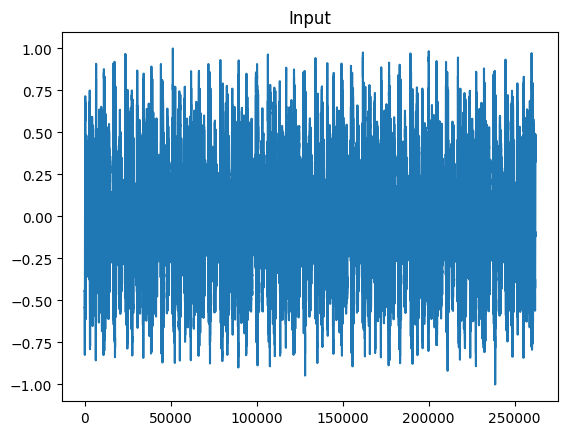

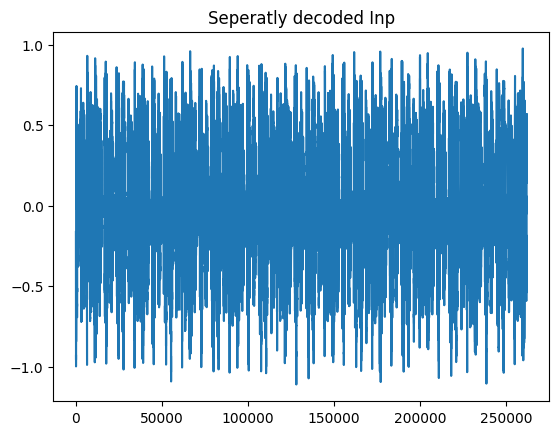

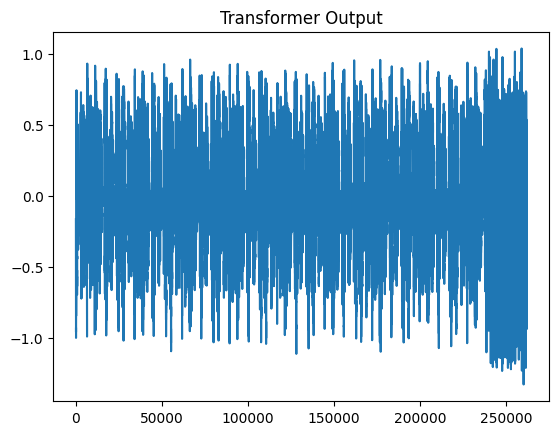

In [ ]:
idx = 7
n = 1
vq_vae.eval()
inp = test_dataset[:24][0].unsqueeze(1).to(device)
with torch.no_grad():
    output, q_z, commit_loss, metrics = vq_vae(inp)
    q_z[idx, -n:] = torch.randint(low=0, high=2048, size=(n,))
    print(q_z[0])
    outp = vq_vae.decode(context.squeeze(1))

print(f"L1 Error True-Out: {np.sum(np.abs(inp[idx][0].cpu().numpy() - output[idx][0].cpu().numpy())):.3e} Out-Split Out:{np.sum(np.abs(outp[idx][0].cpu().numpy() - output[idx][0].cpu().numpy())):.3e}")
plt.plot(inp[idx][0].cpu().numpy())
plt.title("Input")
plt.show()
plt.plot(outp[idx][0].cpu().numpy())
plt.title("Seperatly decoded Inp")
plt.show()
plt.plot(audio[idx][0])
plt.title("Transformer Output")
plt.show()

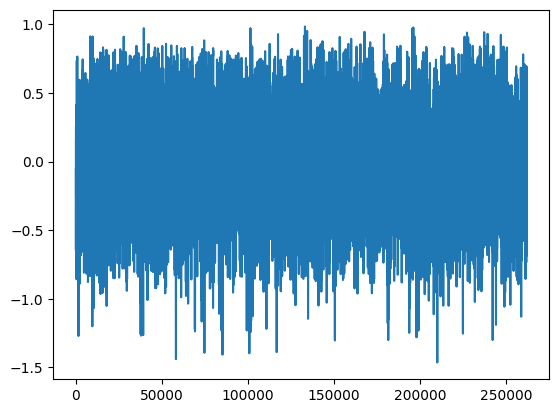

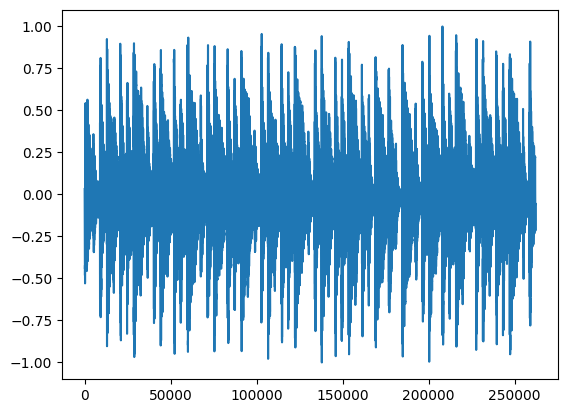

In [ ]:
idx = 0
plt.plot(audio[idx][0])
plt.show()
plt.plot(get_dataloader_item(test_dataloader, idx)[0])
plt.show()

In [ ]:
print(audio[0][-100:].std())
AudioData(data = audio[0][0]).save_audio_file("Results/Jukebox_test1.wav")

0.23921758
